In [14]:
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [15]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y==0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

In [16]:
data_full_raw = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)
full_data = preprocessing.MinMaxScaler((0,1)).fit_transform(data_full_raw)
full_X = full_data[:,:2]
full_Y = full_data[:,2:]

In [17]:
data_full_raw.shape

(3022, 4)

In [18]:
percentages = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
parameter_accuracy = []
performace_accuracy = []

In [19]:
for percentage in percentages:
    data_raw = data_full_raw[np.random.choice(data_full_raw.shape[0], int(percentage * data_full_raw.shape[0]), replace = False),:]
    print(data_raw.shape)
    data = preprocessing.MinMaxScaler((0,1)).fit_transform(data_raw)
    scaler = preprocessing.MinMaxScaler((0,1))
    data2 = scaler.fit_transform(data_raw)
    assert(np.allclose(data,data2))
    X = data[:,:2]
    Y = data[:,2:]
    test_model = model.DistModelBatchNorm(2,5)
    optimizer = optim.Adagrad(test_model.parameters(),lr=0.001)
    loss_fn = multivariate_gaussian_nll

    dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
    train_dataset, val_dataset = utils.splitDataset(dataset1, 0.95)

    train_data = DataLoader(train_dataset,batch_size = 500)
    validation_data = DataLoader(val_dataset, batch_size = 500)
    epochs = 2000
    loss_list, val_loss_list = train.trainProbModel(test_model, train_data, loss_fn, optimizer, num_epochs=epochs, print_every=10, validation_data=validation_data)
    
    x_preds = test_model(torch.Tensor(full_Y))
    mock_simulator = tf.keras.models.load_model('mock_simulator2.0')
    print(x_preds.shape)
    means = x_preds.detach().numpy()[:,:2]
    final_preds = mock_simulator(means).numpy()    
    # for i,d in enumerate(final_preds):
    #     print(Y[i],d)
    print(final_preds)
    parameter_acc = check_acc(full_X,means,margin=.05)
    performance_acc = check_acc(full_Y,final_preds,margin=.05)
    parameter_accuracy.append(parameter_acc)
    performace_accuracy.append(performance_acc)

(302, 4)
t = 10, loss = -0.3927, val loss = -0.3927
t = 20, loss = -0.7930, val loss = -0.7930
t = 30, loss = -1.0555, val loss = -1.0555
t = 40, loss = -1.2875, val loss = -1.2875
t = 50, loss = -1.4016, val loss = -1.4016
t = 60, loss = -1.5707, val loss = -1.5707
t = 70, loss = -1.7026, val loss = -1.7026
t = 80, loss = -1.7677, val loss = -1.7677
t = 90, loss = -1.9181, val loss = -1.9181
t = 100, loss = -1.9756, val loss = -1.9756
t = 110, loss = -2.1140, val loss = -2.1140
t = 120, loss = -2.2084, val loss = -2.2084
t = 130, loss = -2.2570, val loss = -2.2570
t = 140, loss = -2.3751, val loss = -2.3751
t = 150, loss = -2.4302, val loss = -2.4302
t = 160, loss = -2.4955, val loss = -2.4955
t = 170, loss = -2.5444, val loss = -2.5444
t = 180, loss = -2.6570, val loss = -2.6570
t = 190, loss = -2.6954, val loss = -2.6954
t = 200, loss = -2.7304, val loss = -2.7304
t = 210, loss = -2.7344, val loss = -2.7344
t = 220, loss = -2.9014, val loss = -2.9014
t = 230, loss = -2.9001, val los

t = 1860, loss = -6.3680, val loss = -6.3680
t = 1870, loss = -6.6518, val loss = -6.6518
t = 1880, loss = -6.0062, val loss = -6.0062
t = 1890, loss = -6.1858, val loss = -6.1858
t = 1900, loss = -6.4486, val loss = -6.4486
t = 1910, loss = -6.5583, val loss = -6.5583
t = 1920, loss = -6.6590, val loss = -6.6590
t = 1930, loss = -6.5957, val loss = -6.5957
t = 1940, loss = -6.7112, val loss = -6.7112
t = 1950, loss = -6.3281, val loss = -6.3281
t = 1960, loss = -6.6623, val loss = -6.6623
t = 1970, loss = -6.4827, val loss = -6.4827
t = 1980, loss = -6.4777, val loss = -6.4777
t = 1990, loss = -6.7243, val loss = -6.7243
t = 2000, loss = -6.5193, val loss = -6.5193
torch.Size([3022, 5])
[[0.78552526 0.26682255]
 [0.53261995 0.67426217]
 [0.6000682  0.5538848 ]
 ...
 [0.38972938 0.37580448]
 [0.4110376  0.34534013]
 [0.3579868  0.3976169 ]]
Correct = 941 / 3022
Correct = 2203 / 3022
(604, 4)
t = 10, loss = -0.8919, val loss = -0.9072
t = 20, loss = -1.3992, val loss = -1.4275
t = 30, l

t = 1660, loss = -7.5672, val loss = -7.8892
t = 1670, loss = -7.5519, val loss = -7.7917
t = 1680, loss = -7.5231, val loss = -7.8250
t = 1690, loss = -7.4244, val loss = -7.6761
t = 1700, loss = -7.1449, val loss = -7.4293
t = 1710, loss = -7.4748, val loss = -7.9385
t = 1720, loss = -7.1715, val loss = -7.3915
t = 1730, loss = -7.7090, val loss = -7.9890
t = 1740, loss = -7.7589, val loss = -8.0438
t = 1750, loss = -7.2871, val loss = -7.4784
t = 1760, loss = -7.0337, val loss = -7.5086
t = 1770, loss = -7.6811, val loss = -8.0787
t = 1780, loss = -7.9412, val loss = -8.2040
t = 1790, loss = -7.8579, val loss = -8.1423
t = 1800, loss = -7.4311, val loss = -7.6938
t = 1810, loss = -6.7465, val loss = -7.1253
t = 1820, loss = -7.1707, val loss = -7.7550
t = 1830, loss = -7.6057, val loss = -7.8792
t = 1840, loss = -7.8433, val loss = -8.1966
t = 1850, loss = -7.3513, val loss = -7.5422
t = 1860, loss = -7.7457, val loss = -7.9276
t = 1870, loss = -7.5513, val loss = -7.8574
t = 1880, 

t = 1460, loss = -7.0857, val loss = -7.0996
t = 1470, loss = -6.8148, val loss = -6.8079
t = 1480, loss = -6.8695, val loss = -6.9854
t = 1490, loss = -6.8591, val loss = -6.7355
t = 1500, loss = -6.8458, val loss = -6.9513
t = 1510, loss = -6.9973, val loss = -7.0053
t = 1520, loss = -6.9516, val loss = -6.9784
t = 1530, loss = -6.9147, val loss = -6.8687
t = 1540, loss = -6.6455, val loss = -6.7722
t = 1550, loss = -7.2964, val loss = -7.3408
t = 1560, loss = -7.3397, val loss = -7.3641
t = 1570, loss = -6.7122, val loss = -6.7793
t = 1580, loss = -7.0708, val loss = -7.1707
t = 1590, loss = -7.1102, val loss = -7.0580
t = 1600, loss = -6.6950, val loss = -6.7590
t = 1610, loss = -7.1065, val loss = -7.1319
t = 1620, loss = -7.0380, val loss = -7.0967
t = 1630, loss = -7.4612, val loss = -7.4896
t = 1640, loss = -6.8358, val loss = -6.9330
t = 1650, loss = -6.8063, val loss = -6.8587
t = 1660, loss = -7.1962, val loss = -7.1821
t = 1670, loss = -6.9586, val loss = -7.0775
t = 1680, 

t = 1260, loss = -6.9649, val loss = -7.1007
t = 1270, loss = -7.0345, val loss = -7.0396
t = 1280, loss = -6.6991, val loss = -7.0294
t = 1290, loss = -7.1031, val loss = -7.1836
t = 1300, loss = -7.2358, val loss = -7.2502
t = 1310, loss = -7.3833, val loss = -7.6019
t = 1320, loss = -7.3927, val loss = -7.6285
t = 1330, loss = -7.2886, val loss = -7.4157
t = 1340, loss = -7.4811, val loss = -7.6610
t = 1350, loss = -7.0964, val loss = -7.0848
t = 1360, loss = -7.3256, val loss = -7.5527
t = 1370, loss = -7.1948, val loss = -7.4758
t = 1380, loss = -6.9318, val loss = -7.1489
t = 1390, loss = -7.3418, val loss = -7.5603
t = 1400, loss = -7.4361, val loss = -7.5238
t = 1410, loss = -7.2955, val loss = -7.4610
t = 1420, loss = -7.1766, val loss = -7.2824
t = 1430, loss = -6.9988, val loss = -7.0219
t = 1440, loss = -7.0911, val loss = -7.1186
t = 1450, loss = -7.3350, val loss = -7.4677
t = 1460, loss = -7.3369, val loss = -7.5620
t = 1470, loss = -7.3052, val loss = -7.3957
t = 1480, 

t = 1060, loss = -6.8535, val loss = -6.9323
t = 1070, loss = -6.6920, val loss = -6.7405
t = 1080, loss = -6.5897, val loss = -6.5973
t = 1090, loss = -6.8648, val loss = -6.9317
t = 1100, loss = -6.7729, val loss = -6.7523
t = 1110, loss = -7.0723, val loss = -7.1311
t = 1120, loss = -6.8401, val loss = -6.8188
t = 1130, loss = -6.7676, val loss = -6.7642
t = 1140, loss = -7.1178, val loss = -7.1606
t = 1150, loss = -6.5080, val loss = -6.4746
t = 1160, loss = -6.9713, val loss = -6.9956
t = 1170, loss = -7.0487, val loss = -7.0942
t = 1180, loss = -6.6838, val loss = -6.6710
t = 1190, loss = -7.1189, val loss = -7.2016
t = 1200, loss = -6.9231, val loss = -6.9167
t = 1210, loss = -7.0675, val loss = -7.0729
t = 1220, loss = -6.5239, val loss = -6.5224
t = 1230, loss = -7.1498, val loss = -7.1521
t = 1240, loss = -6.8464, val loss = -6.8074
t = 1250, loss = -6.8624, val loss = -6.8765
t = 1260, loss = -7.0335, val loss = -7.0708
t = 1270, loss = -6.6779, val loss = -6.6945
t = 1280, 

t = 850, loss = -7.0713, val loss = -7.2194
t = 860, loss = -6.9450, val loss = -7.1876
t = 870, loss = -6.7644, val loss = -6.9897
t = 880, loss = -7.0398, val loss = -7.1738
t = 890, loss = -6.4133, val loss = -6.0565
t = 900, loss = -7.1084, val loss = -7.2818
t = 910, loss = -6.6355, val loss = -6.8856
t = 920, loss = -6.9326, val loss = -7.1557
t = 930, loss = -6.7261, val loss = -6.9732
t = 940, loss = -7.0287, val loss = -7.0843
t = 950, loss = -7.1705, val loss = -7.3571
t = 960, loss = -6.9816, val loss = -7.2133
t = 970, loss = -7.0879, val loss = -7.1004
t = 980, loss = -6.9024, val loss = -6.8178
t = 990, loss = -7.1240, val loss = -7.0194
t = 1000, loss = -6.9292, val loss = -7.2995
t = 1010, loss = -6.9695, val loss = -7.1604
t = 1020, loss = -6.8688, val loss = -6.9499
t = 1030, loss = -7.0127, val loss = -7.2349
t = 1040, loss = -6.9641, val loss = -6.8911
t = 1050, loss = -6.9454, val loss = -6.8675
t = 1060, loss = -7.4170, val loss = -7.6097
t = 1070, loss = -7.0877,

t = 640, loss = -6.6377, val loss = -7.2061
t = 650, loss = -6.5461, val loss = -7.1556
t = 660, loss = -6.8001, val loss = -7.0656
t = 670, loss = -6.9375, val loss = -7.6119
t = 680, loss = -6.9079, val loss = -7.3177
t = 690, loss = -6.9456, val loss = -7.3528
t = 700, loss = -6.9538, val loss = -7.6223
t = 710, loss = -6.9380, val loss = -7.4738
t = 720, loss = -6.8836, val loss = -7.3205
t = 730, loss = -6.9234, val loss = -7.5534
t = 740, loss = -6.5198, val loss = -6.8954
t = 750, loss = -7.1155, val loss = -7.6319
t = 760, loss = -6.9451, val loss = -7.3484
t = 770, loss = -7.2014, val loss = -7.7277
t = 780, loss = -6.8592, val loss = -7.1935
t = 790, loss = -7.0382, val loss = -7.4960
t = 800, loss = -6.6848, val loss = -6.9800
t = 810, loss = -7.2119, val loss = -7.8168
t = 820, loss = -6.9033, val loss = -7.4374
t = 830, loss = -6.9561, val loss = -7.5847
t = 840, loss = -7.2319, val loss = -7.7259
t = 850, loss = -6.9848, val loss = -7.6273
t = 860, loss = -6.4884, val los

t = 430, loss = -5.8890, val loss = -5.7168
t = 440, loss = -6.2496, val loss = -6.3069
t = 450, loss = -6.1634, val loss = -6.3879
t = 460, loss = -6.2964, val loss = -6.3215
t = 470, loss = -6.3117, val loss = -6.3646
t = 480, loss = -6.1306, val loss = -6.1965
t = 490, loss = -6.2984, val loss = -6.2359
t = 500, loss = -6.2320, val loss = -6.0721
t = 510, loss = -5.9092, val loss = -5.9081
t = 520, loss = -6.2531, val loss = -6.0205
t = 530, loss = -6.2139, val loss = -6.3046
t = 540, loss = -6.4684, val loss = -6.4591
t = 550, loss = -6.5668, val loss = -6.6951
t = 560, loss = -6.3400, val loss = -6.4766
t = 570, loss = -6.6507, val loss = -6.6290
t = 580, loss = -6.5286, val loss = -6.5383
t = 590, loss = -6.6359, val loss = -6.7467
t = 600, loss = -6.3181, val loss = -6.4789
t = 610, loss = -6.5374, val loss = -6.6215
t = 620, loss = -6.7122, val loss = -6.7952
t = 630, loss = -6.3600, val loss = -6.3626
t = 640, loss = -6.7796, val loss = -6.8765
t = 650, loss = -6.1648, val los

t = 220, loss = -5.5306, val loss = -5.8741
t = 230, loss = -5.6667, val loss = -6.0716
t = 240, loss = -5.6799, val loss = -5.8793
t = 250, loss = -5.5042, val loss = -5.7830
t = 260, loss = -5.8853, val loss = -6.3081
t = 270, loss = -5.8392, val loss = -6.1947
t = 280, loss = -5.8912, val loss = -6.2072
t = 290, loss = -6.0427, val loss = -6.1766
t = 300, loss = -5.9564, val loss = -5.8194
t = 310, loss = -6.2913, val loss = -6.3704
t = 320, loss = -6.2967, val loss = -6.6009
t = 330, loss = -6.2004, val loss = -6.2344
t = 340, loss = -5.8029, val loss = -6.5537
t = 350, loss = -6.1910, val loss = -6.5604
t = 360, loss = -6.0511, val loss = -6.7106
t = 370, loss = -5.7872, val loss = -6.1872
t = 380, loss = -6.6304, val loss = -6.8467
t = 390, loss = -6.6176, val loss = -7.0020
t = 400, loss = -6.3568, val loss = -6.7768
t = 410, loss = -6.5879, val loss = -6.8869
t = 420, loss = -6.1130, val loss = -6.6659
t = 430, loss = -6.4453, val loss = -6.7131
t = 440, loss = -6.6877, val los

In [20]:
print(parameter_accuracy)
print(performace_accuracy)

[0.3113831899404368, 0.36499007279947054, 0.5062872270019855, 0.5062872270019855, 0.5886829913964262, 0.6320317670416943, 0.686300463269358, 0.714427531436135, 0.7352746525479815]
[0.728987425545996, 0.813037723362012, 0.9185969556585043, 0.8908007941760424, 0.9099933818663137, 0.9460622104566512, 0.9434149569821311, 0.971211118464593, 0.9880873593646592]


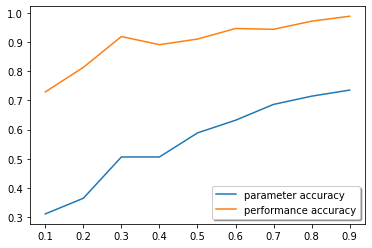

In [21]:
fig, ax = plt.subplots()

ax.plot(percentages, parameter_accuracy, label='parameter accuracy')
ax.plot(percentages, performace_accuracy, label = 'performance accuracy')
legend = ax.legend(loc='lower right', shadow=True)
plt.show()